# Job Title Classification for Organizational Role Segmentation

## Introduction

This notebook presents an exploratory data analysis (EDA) and machine learning approach to solve a crucial marketing challenge: automatically classifying job titles according to the Job Level Hierarchy/Organizational Role Segmentation.

### Why is this important?

Accurate classification of organizational roles is invaluable for marketing strategies:

1. **Targeted Communication**: Tailor messages based on decision-making power and responsibilities.
2. **Product Positioning**: Market specific products to appropriate organizational levels.
3. **Lead Qualification**: Identify key decision-makers in B2B marketing efforts.
4. **Content Strategy**: Create content addressing the needs of each job level.
5. **Account-Based Marketing (ABM)**: Map out target organization structures.
6. **Value Proposition Alignment**: Align marketing messages with level-specific priorities and pain points.
7. **Event Planning**: Organize tailored events for specific job levels.
8. **Sales Enablement**: Provide insights for approaching different organizational levels.

### Notebook Overview

This notebook walks through the following steps:
1. Data preprocessing
2. Model and architecture selection
3. Training and testing the model
4. Interpreting results

### Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('./JobLevelData.xlsx')
display(df.head())
display(df.info())
display(df.describe())


,Title,Column 1,Column 2,Column 3,Column 4
0,Vice President / Director of Systems Engineering,Vice President,NaN,NaN,NaN
1,Systems Engineer; Systems Architect,Manager,Individual Contributor/Staff,NaN,NaN
2,"Executive Director, Global IT Infrastructure /...",Director,Chief Officer,NaN,NaN
3,CTO/Executive Director of Technology Services,Director,Chief Officer,NaN,NaN
4,"Vice President, CIO",Vice President,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     2240 non-null   object
 1   Column 1  2230 non-null   object
 2   Column 2  133 non-null    object
 3   Column 3  12 non-null     object
 4   Column 4  11 non-null     object
dtypes: object(5)
memory usage: 87.6+ KB


None

,Title,Column 1,Column 2,Column 3,Column 4
count,2240,2230,133,12,11
unique,2240,6,4,2,1
top,Vice President / Director of Systems Engineering,Individual Contributor/Staff,Individual Contributor/Staff,Individual Contributor/Staff,Director
freq,1,1039,55,11,11


In [3]:
unique_values = set()

for column in ['Column 1', 'Column 2', 'Column 3', 'Column 4']:
    values = df[column].dropna().unique().tolist()
    unique_values.update(values)

print(f"\nUnique values across all columns:")
print(f"Number of unique values: {len(unique_values)}")
print("Unique values:")
print(list(unique_values))


Unique values across all columns:
Number of unique values: 6
Unique values:
['Individual Contributor/Staff', 'Owner', 'Director', 'Chief Officer', 'Vice President', 'Manager']


In [4]:
display(df[df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].isna().all(axis=1)])

,Title,Column 1,Column 2,Column 3,Column 4
29,CINO,NaN,NaN,NaN,NaN
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
829,Release of Information Tech II,NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN
1406,"Global People Systems, Processes and Informati...",NaN,NaN,NaN,NaN
1713,Supplier Quality Engineer,NaN,NaN,NaN,NaN
1785,RC Environmental and Cyber Specialized Subscri...,NaN,NaN,NaN,NaN
2182,Senior Independedirector and Chair of the Cust...,NaN,NaN,NaN,NaN


In [5]:
# manualy input some missing values based on the job title and internet research

df.loc[29, 'Column 1'] = 'Chief Officer'                        # CINO
df.loc[829, 'Column 1'] = 'Individual Contributor/Staff'        # Release of Information Tech II
df.loc[1406, 'Column 1'] = 'Manager'                            # Global People Systems, Processes and Information Manager
df.loc[1713, 'Column 1'] = 'Individual Contributor/Staff'       # RC Environmental and Cyber Specialized Subscription Manager
df.loc[1785, 'Column 1'] = 'Manager'                            # RC Environmental and Cyber Specialized Subscription Manager
df.loc[2182, 'Column 1'] = 'Director'                           # Senior IndependeDirector and Chair of the Customer and Communities Network
df.loc[2182, 'Title'] = 'Senior Independet Director and Chair of the Customer and Communities Network'        # Senior IndependeDirector and Chair of the Customer and Communities Network


In [6]:
display(df[df[['Column 1', 'Column 2', 'Column 3', 'Column 4']].isna().all(axis=1)])

,Title,Column 1,Column 2,Column 3,Column 4
341,Ticari Subesi Muduru,NaN,NaN,NaN,NaN
511,"Governor, Chair of Board Risk and Audit Commit...",NaN,NaN,NaN,NaN
764,"Former Director, Compensation and Benefits",NaN,NaN,NaN,NaN
1257,"Shareholder, Chair of Tax Section",NaN,NaN,NaN,NaN


# write why we use one hot encoding

In [7]:
# One hot encoding
columns_to_encode = ['Column 1', 'Column 2', 'Column 3', 'Column 4']

one_hot_encoded = pd.DataFrame()

for value in unique_values:
    one_hot_encoded[f'Label_{value}'] = df[columns_to_encode].eq(value).any(axis=1).astype(int)

df = pd.concat([df['Title'], one_hot_encoded], axis=1)
display(df.head())

,Title,Label_Individual Contributor/Staff,Label_Owner,Label_Director,Label_Chief Officer,Label_Vice President,Label_Manager
0,Vice President / Director of Systems Engineering,0,0,0,0,1,0
1,Systems Engineer; Systems Architect,1,0,0,0,0,1
2,"Executive Director, Global IT Infrastructure /...",0,0,1,1,0,0
3,CTO/Executive Director of Technology Services,0,0,1,1,0,0
4,"Vice President, CIO",0,0,0,0,1,0


Distribution of labels across all columns:
Label_Individual Contributor/Staff: 1107 (49.42%)
Label_Director: 498 (22.23%)
Label_Vice President: 403 (17.99%)
Label_Manager: 213 (9.51%)
Label_Chief Officer: 167 (7.46%)
Label_Owner: 4 (0.18%)


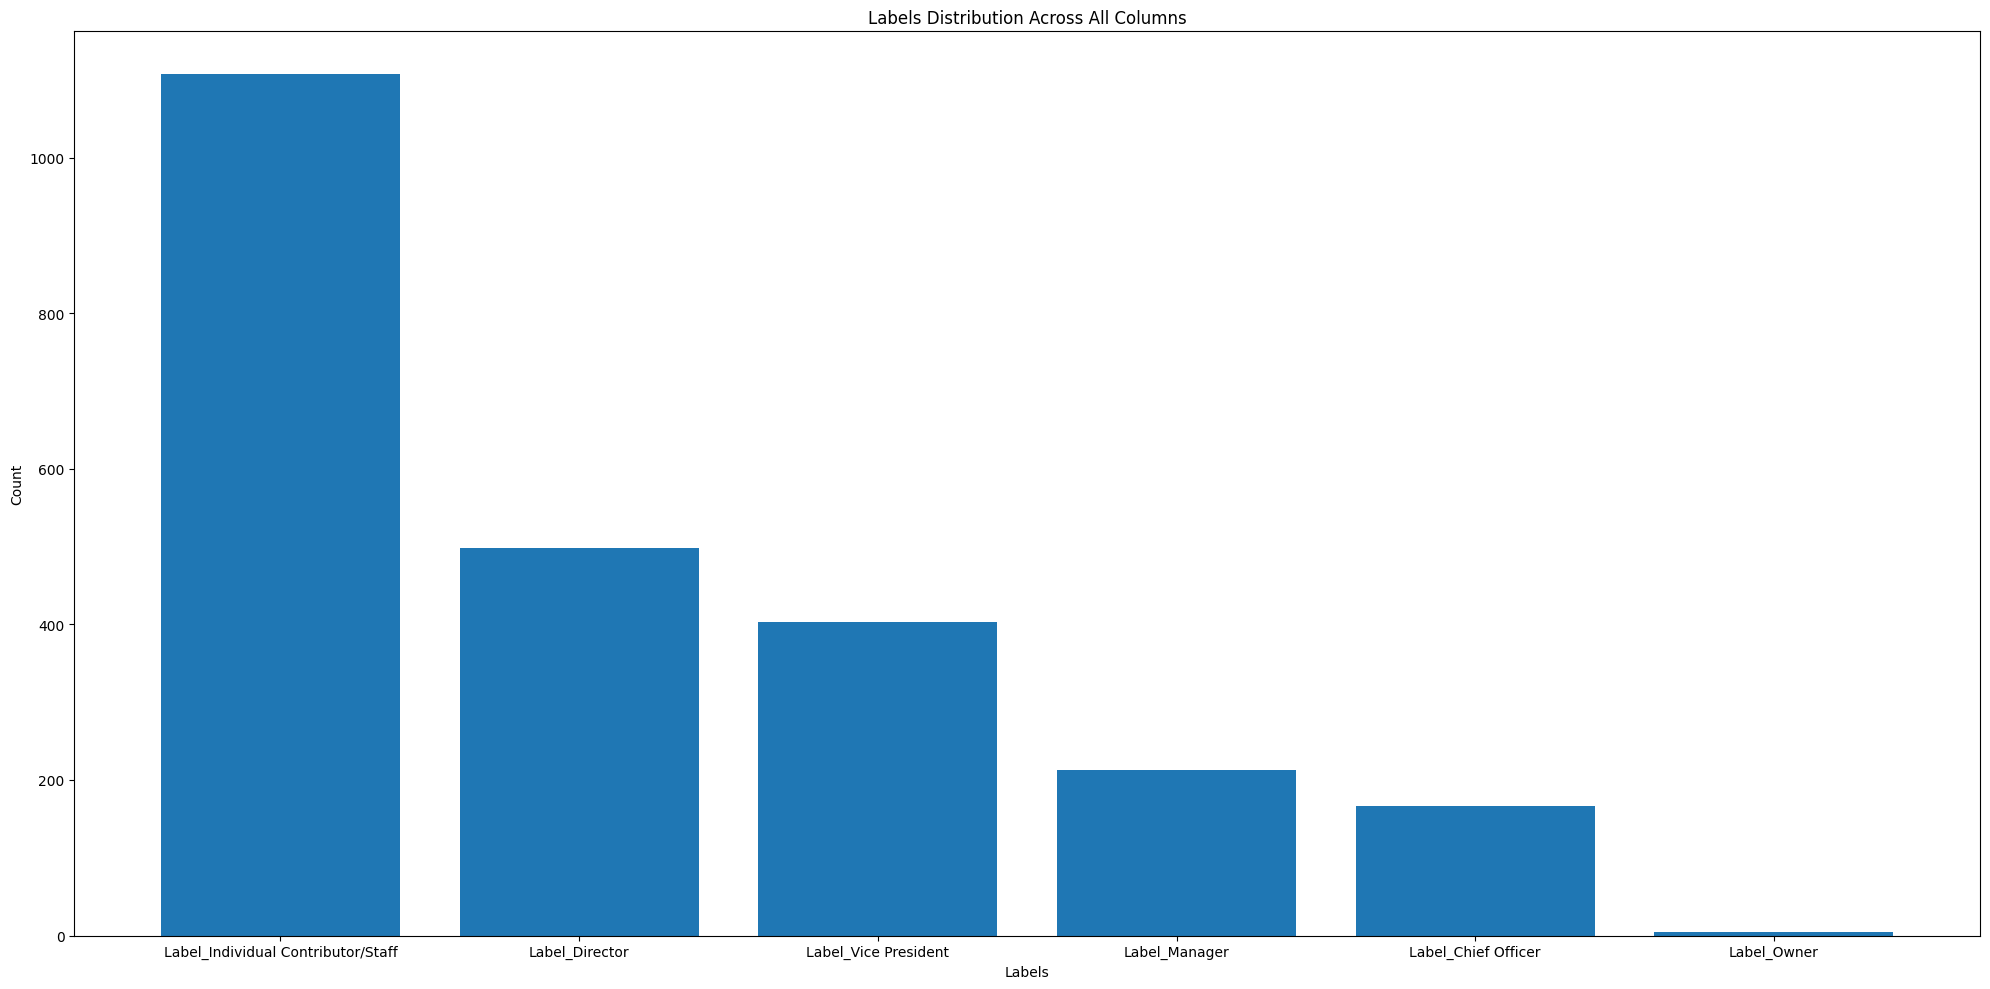

In [8]:
label_distribution = {}

for column in unique_values:
    count = df['Label_' + column].sum()
    label_distribution['Label_' + column] = count

# Sort the distribution by count in descending order
sorted_distribution = sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)

total_count = df.shape[0]
print("Distribution of labels across all columns:")
for label, count in sorted_distribution:
    percentage = (count / total_count) * 100
    print(f"{label}: {count} ({percentage:.2f}%)")

# Visualize all labels
sorted_distribution = dict(sorted_distribution)
plt.figure(figsize=(20, 10))  # Increased figure size to accommodate all labels
plt.bar(sorted_distribution.keys(), sorted_distribution.values())
plt.title("Labels Distribution Across All Columns")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Label Distribution Analysis

The distribution of labels across all columns reflects a typical organizational structure, with a large base of individual contributors and progressively fewer positions at higher levels of management.

#### Data Imbalance Issue:
The Owner category is significantly underrepresented with only 4 instances (0.18%) in the entire dataset. This extreme imbalance could lead to poor model performance in identifying and classifying Owner roles.

To address the data imbalance, particularly for the Owner category, it would be valuable to expand the dataset by manually searching for additional job descriptions that fall into this category. This effort would help balance the dataset and potentially improve model performance, especially for identifying the Owner class.


In [9]:
import re
import nltk
from nltk.corpus import stopwords

# basic preprocessing: lowercase, remove special characters,
# remove all numbers, remove extra spaces
df['Title'] = df['Title'].str.lower()
df['Title'] = df['Title'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
df['Title'] = df['Title'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))

# remove stop words
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
stop_words.remove('it') # it is a stop word but it used a lot in the job titles
df['Title'] = df['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# normalize the job titles:
# i.e sr -> senior, jr -> junior, vp -> vice president, etc.
job_title_dict = {
    # misspelings
    'vise': 'vice',
    'senoir': 'senior',
    'maneger': 'manager',
    'assistent': 'assistant',
    'supervisr': 'supervisor',
    'analist': 'analyst',
    'enginere': 'engineer',
    'developr': 'developer',
    'programer': 'programmer',
    'acountant': 'accountant',
    'lawer': 'lawyer',
    'docter': 'doctor',
    'analista': 'analyst',
    # short forms
    'dev': 'developer',
    'dev.': 'developer',
    'eng': 'engineer',
    'eng.': 'engineer',
    'engr': 'engineer',
    'engr.': 'engineer',
    # title prefixes 
    'reg': 'regional',
    'reg.': 'regional',
    'assoc': 'associate',
    'assoc.': 'associate',
    'asst': 'assistant',
    'asst.': 'assistant',
    'exec': 'executive',
    'exec.': 'executive',
    'deputy': 'deputy',
    'deputy.': 'deputy',
    'mng': 'managing',
    'mng.': 'managing',
    # expertise level
    'sr': 'senior',
    'sr.': 'senior',
    'snr': 'senior',
    'snr.': 'senior',
    'sen': 'senior',
    'sen.': 'senior',
    'jr': 'junior',
    'jr.': 'junior',
    'jnr': 'junior',
    'jnr.': 'junior',
    'jun': 'junior',
    'jun.': 'junior',
    'mid': 'middle',
    'mid.': 'middle',
    'mdl': 'middle',
    'mdl.': 'middle',
    # vice president
    'vp': 'vice president',
    'svp': 'senior vice president',
    'evp': 'executive vice president',
    'avp': 'assistant vice president',
    'sevp': 'senior executive vice president',
    'gvp': 'group vice president',
    'dvp': 'divisional vice president',
    'rvp': 'regional vice president',
    'cvp': 'corporate vice president',
    'davp': 'deputy assistant vice president',
    'savp': 'senior assistant vice president',
    'mvp': 'managing vice president',
    'arvp': 'associate regional vice president',
    # c level officers
    'cfo': 'chief financial officer',
    'coo': 'chief operating officer',
    'cto': 'chief technology officer',
    'cio': 'chief information officer',
    'chro': 'chief human resources officer',
    'cdo': 'chief data officer',
    'cmo': 'chief marketing officer',
    'cso': 'chief sales officer',
    'cco': 'chief communications officer',
    'cro': 'chief relationship officer',
    # directors
    'dir': 'director',
    'dir.': 'director',
    # managers
    'mgr': 'manager',
    'mgr.': 'manager',
    'mng': 'manager',
    'mng.': 'manager',
    'mngr': 'manager',
    'mngr.': 'manager',
}

# Function to normalize job titles
def normalize_job_title(title):
    words = title.split()
    normalized_words = []
    for word in words:
        normalized_words.append(job_title_dict.get(word, word))
    return ' '.join(normalized_words)

df['Title'] = df['Title'].apply(normalize_job_title)

display(df.head(10))
# df.to_excel('processed_job_titles.xlsx', index=False)



,Title,Label_Individual Contributor/Staff,Label_Owner,Label_Director,Label_Chief Officer,Label_Vice President,Label_Manager
0,vice president director systems engineering,0,0,0,0,1,0
1,systems engineer systems architect,1,0,0,0,0,1
2,executive director global it infrastructure ch...,0,0,1,1,0,0
3,chief technology officer executive director te...,0,0,1,1,0,0
4,vice president chief information officer,0,0,0,0,1,0
5,chief information officer cissp,0,0,0,1,0,0
6,chief information officer platform services,0,0,0,1,0,0
7,chief technology officer head marketing,0,0,0,1,0,0
8,chief information systems officer,0,0,0,1,0,0
9,chief data architect,0,0,0,1,0,0


In [10]:
import gensim.downloader as api
from gensim.models import KeyedVectors

model = api.load("word2vec-google-news-300")

def create_embedding(title):
    words = title.split()
    word_vectors = [model[word] for word in words if word in model.key_to_index]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

df['embedding'] = df['Title'].apply(create_embedding)

display(df.head())


,Title,Label_Individual Contributor/Staff,Label_Owner,Label_Director,Label_Chief Officer,Label_Vice President,Label_Manager,embedding
0,vice president director systems engineering,0,0,0,0,1,0,"[-0.044934083, -0.10429688, 0.10664062, -0.023..."
1,systems engineer systems architect,1,0,0,0,0,1,"[0.061279297, -0.036132812, 0.08505249, -0.025..."
2,executive director global it infrastructure ch...,0,0,1,1,0,0,"[0.012003581, -0.09677315, 0.051801894, -0.108..."
3,chief technology officer executive director te...,0,0,1,1,0,0,"[0.020472934, -0.105163574, 0.09854998, -0.098..."
4,vice president chief information officer,0,0,0,0,1,0,"[0.004138184, -0.12734374, 0.11902466, -0.1625..."


In [11]:
print(sorted_distribution.keys())


dict_keys(['Label_Individual Contributor/Staff', 'Label_Director', 'Label_Vice President', 'Label_Manager', 'Label_Chief Officer', 'Label_Owner'])


In [12]:
# Create 6 datasets for each label
datasets = []
sorted_unique_values = list(sorted_distribution.keys())

for column in sorted_unique_values:
    print(column)
    # Create a new dataset with embeddings and the current one-hot encoded column
    dataset = pd.DataFrame(df['embedding'].tolist(), columns=[f'emb_{i}' for i in range(model.vector_size)])
    dataset[column] = df[column]
    
    datasets.append((column, dataset))

# Display information about each dataset
for column, dataset in datasets:
    print(f"\nDataset for {column}:")
    print(f"Shape: {dataset.shape}")
    print(f"Positive samples: {dataset[column].sum()}")
    print(f"Negative samples: {len(dataset) - dataset[column].sum()}")
    print("\nFirst few rows:")
    display(dataset.head())

Label_Individual Contributor/Staff
Label_Director
Label_Vice President
Label_Manager
Label_Chief Officer
Label_Owner

Dataset for Label_Individual Contributor/Staff:
Shape: (2240, 301)
Positive samples: 1107
Negative samples: 1133

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Individual Contributor/Staff
0,-0.044934,-0.104297,0.106641,-0.023315,-0.113037,-0.021436,0.114648,-0.090186,0.041553,-0.053809,...,0.021826,-0.157935,0.114453,0.054565,-0.095886,0.077026,0.006543,0.136005,0.106604,0
1,0.061279,-0.036133,0.085052,-0.025391,-0.141113,0.200684,-0.027344,-0.024658,0.058746,-0.031403,...,0.063904,-0.058365,0.152344,0.055939,-0.086792,-0.068909,-0.223145,0.075851,0.005035,1
2,0.012004,-0.096773,0.051802,-0.108236,-0.079414,-0.050076,0.097629,-0.057427,-0.002143,-0.088759,...,0.021783,-0.031128,0.053813,-0.054036,-0.002455,0.110914,-0.008898,0.103597,0.015598,0
3,0.020473,-0.105164,0.098550,-0.098772,-0.067679,-0.039734,0.122995,-0.041539,-0.049247,-0.099784,...,-0.026611,-0.108050,0.064104,-0.019793,-0.046247,0.178362,0.026293,0.108067,0.132464,0
4,0.004138,-0.127344,0.119025,-0.162573,-0.074878,-0.103418,0.142188,-0.014941,0.008545,-0.125586,...,-0.037646,-0.117236,-0.034375,-0.027393,-0.041492,0.048535,-0.019922,0.150684,0.107031,0



Dataset for Label_Director:
Shape: (2240, 301)
Positive samples: 498
Negative samples: 1742

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Director
0,-0.044934,-0.104297,0.106641,-0.023315,-0.113037,-0.021436,0.114648,-0.090186,0.041553,-0.053809,...,0.021826,-0.157935,0.114453,0.054565,-0.095886,0.077026,0.006543,0.136005,0.106604,0
1,0.061279,-0.036133,0.085052,-0.025391,-0.141113,0.200684,-0.027344,-0.024658,0.058746,-0.031403,...,0.063904,-0.058365,0.152344,0.055939,-0.086792,-0.068909,-0.223145,0.075851,0.005035,0
2,0.012004,-0.096773,0.051802,-0.108236,-0.079414,-0.050076,0.097629,-0.057427,-0.002143,-0.088759,...,0.021783,-0.031128,0.053813,-0.054036,-0.002455,0.110914,-0.008898,0.103597,0.015598,1
3,0.020473,-0.105164,0.098550,-0.098772,-0.067679,-0.039734,0.122995,-0.041539,-0.049247,-0.099784,...,-0.026611,-0.108050,0.064104,-0.019793,-0.046247,0.178362,0.026293,0.108067,0.132464,1
4,0.004138,-0.127344,0.119025,-0.162573,-0.074878,-0.103418,0.142188,-0.014941,0.008545,-0.125586,...,-0.037646,-0.117236,-0.034375,-0.027393,-0.041492,0.048535,-0.019922,0.150684,0.107031,0



Dataset for Label_Vice President:
Shape: (2240, 301)
Positive samples: 403
Negative samples: 1837

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Vice President
0,-0.044934,-0.104297,0.106641,-0.023315,-0.113037,-0.021436,0.114648,-0.090186,0.041553,-0.053809,...,0.021826,-0.157935,0.114453,0.054565,-0.095886,0.077026,0.006543,0.136005,0.106604,1
1,0.061279,-0.036133,0.085052,-0.025391,-0.141113,0.200684,-0.027344,-0.024658,0.058746,-0.031403,...,0.063904,-0.058365,0.152344,0.055939,-0.086792,-0.068909,-0.223145,0.075851,0.005035,0
2,0.012004,-0.096773,0.051802,-0.108236,-0.079414,-0.050076,0.097629,-0.057427,-0.002143,-0.088759,...,0.021783,-0.031128,0.053813,-0.054036,-0.002455,0.110914,-0.008898,0.103597,0.015598,0
3,0.020473,-0.105164,0.098550,-0.098772,-0.067679,-0.039734,0.122995,-0.041539,-0.049247,-0.099784,...,-0.026611,-0.108050,0.064104,-0.019793,-0.046247,0.178362,0.026293,0.108067,0.132464,0
4,0.004138,-0.127344,0.119025,-0.162573,-0.074878,-0.103418,0.142188,-0.014941,0.008545,-0.125586,...,-0.037646,-0.117236,-0.034375,-0.027393,-0.041492,0.048535,-0.019922,0.150684,0.107031,1



Dataset for Label_Manager:
Shape: (2240, 301)
Positive samples: 213
Negative samples: 2027

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Manager
0,-0.044934,-0.104297,0.106641,-0.023315,-0.113037,-0.021436,0.114648,-0.090186,0.041553,-0.053809,...,0.021826,-0.157935,0.114453,0.054565,-0.095886,0.077026,0.006543,0.136005,0.106604,0
1,0.061279,-0.036133,0.085052,-0.025391,-0.141113,0.200684,-0.027344,-0.024658,0.058746,-0.031403,...,0.063904,-0.058365,0.152344,0.055939,-0.086792,-0.068909,-0.223145,0.075851,0.005035,1
2,0.012004,-0.096773,0.051802,-0.108236,-0.079414,-0.050076,0.097629,-0.057427,-0.002143,-0.088759,...,0.021783,-0.031128,0.053813,-0.054036,-0.002455,0.110914,-0.008898,0.103597,0.015598,0
3,0.020473,-0.105164,0.098550,-0.098772,-0.067679,-0.039734,0.122995,-0.041539,-0.049247,-0.099784,...,-0.026611,-0.108050,0.064104,-0.019793,-0.046247,0.178362,0.026293,0.108067,0.132464,0
4,0.004138,-0.127344,0.119025,-0.162573,-0.074878,-0.103418,0.142188,-0.014941,0.008545,-0.125586,...,-0.037646,-0.117236,-0.034375,-0.027393,-0.041492,0.048535,-0.019922,0.150684,0.107031,0



Dataset for Label_Chief Officer:
Shape: (2240, 301)
Positive samples: 167
Negative samples: 2073

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Chief Officer
0,-0.044934,-0.104297,0.106641,-0.023315,-0.113037,-0.021436,0.114648,-0.090186,0.041553,-0.053809,...,0.021826,-0.157935,0.114453,0.054565,-0.095886,0.077026,0.006543,0.136005,0.106604,0
1,0.061279,-0.036133,0.085052,-0.025391,-0.141113,0.200684,-0.027344,-0.024658,0.058746,-0.031403,...,0.063904,-0.058365,0.152344,0.055939,-0.086792,-0.068909,-0.223145,0.075851,0.005035,0
2,0.012004,-0.096773,0.051802,-0.108236,-0.079414,-0.050076,0.097629,-0.057427,-0.002143,-0.088759,...,0.021783,-0.031128,0.053813,-0.054036,-0.002455,0.110914,-0.008898,0.103597,0.015598,1
3,0.020473,-0.105164,0.098550,-0.098772,-0.067679,-0.039734,0.122995,-0.041539,-0.049247,-0.099784,...,-0.026611,-0.108050,0.064104,-0.019793,-0.046247,0.178362,0.026293,0.108067,0.132464,1
4,0.004138,-0.127344,0.119025,-0.162573,-0.074878,-0.103418,0.142188,-0.014941,0.008545,-0.125586,...,-0.037646,-0.117236,-0.034375,-0.027393,-0.041492,0.048535,-0.019922,0.150684,0.107031,0



Dataset for Label_Owner:
Shape: (2240, 301)
Positive samples: 4
Negative samples: 2236

First few rows:


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299,Label_Owner
0,-0.044934,-0.104297,0.106641,-0.023315,-0.113037,-0.021436,0.114648,-0.090186,0.041553,-0.053809,...,0.021826,-0.157935,0.114453,0.054565,-0.095886,0.077026,0.006543,0.136005,0.106604,0
1,0.061279,-0.036133,0.085052,-0.025391,-0.141113,0.200684,-0.027344,-0.024658,0.058746,-0.031403,...,0.063904,-0.058365,0.152344,0.055939,-0.086792,-0.068909,-0.223145,0.075851,0.005035,0
2,0.012004,-0.096773,0.051802,-0.108236,-0.079414,-0.050076,0.097629,-0.057427,-0.002143,-0.088759,...,0.021783,-0.031128,0.053813,-0.054036,-0.002455,0.110914,-0.008898,0.103597,0.015598,0
3,0.020473,-0.105164,0.098550,-0.098772,-0.067679,-0.039734,0.122995,-0.041539,-0.049247,-0.099784,...,-0.026611,-0.108050,0.064104,-0.019793,-0.046247,0.178362,0.026293,0.108067,0.132464,0
4,0.004138,-0.127344,0.119025,-0.162573,-0.074878,-0.103418,0.142188,-0.014941,0.008545,-0.125586,...,-0.037646,-0.117236,-0.034375,-0.027393,-0.041492,0.048535,-0.019922,0.150684,0.107031,0



Processing dataset for Label_Individual Contributor/Staff


 97%|█████████▋| 28/29 [04:38<00:08,  8.63s/it]

[LightGBM] [Info] Number of positive: 874, number of negative: 918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487723 -> initscore=-0.049117
[LightGBM] [Info] Start training from score -0.049117


100%|██████████| 29/29 [04:47<00:00,  9.91s/it]

Model performance for Label_Individual Contributor/Staff:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.96,0.96,0.96,0.96,0.67
SGDClassifier,0.95,0.95,0.95,0.95,0.14
LogisticRegression,0.95,0.95,0.95,0.95,0.70
RidgeClassifierCV,0.95,0.95,0.95,0.95,62.17
NuSVC,0.94,0.94,0.94,0.94,1.59
PassiveAggressiveClassifier,0.94,0.94,0.94,0.94,0.28
Perceptron,0.94,0.94,0.94,0.94,0.27
LinearDiscriminantAnalysis,0.94,0.94,0.94,0.94,87.47
RidgeClassifier,0.94,0.94,0.94,0.94,4.87


<Figure size 1000x600 with 0 Axes>

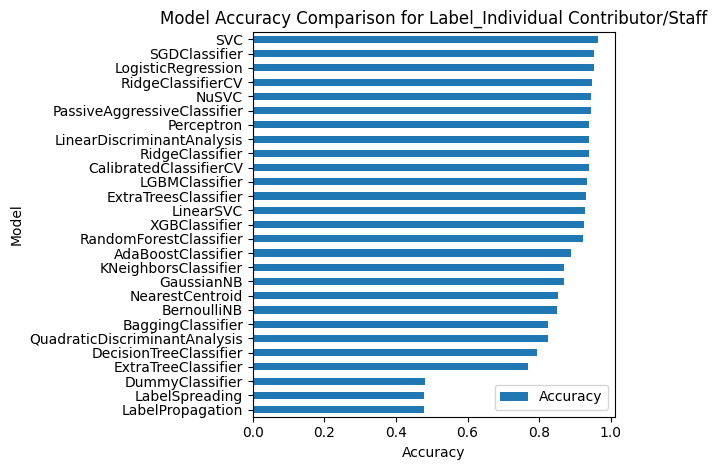


Processing dataset for Label_Director


 97%|█████████▋| 28/29 [04:47<00:10, 10.02s/it]

[LightGBM] [Info] Number of positive: 404, number of negative: 1388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225446 -> initscore=-1.234204
[LightGBM] [Info] Start training from score -1.234204


100%|██████████| 29/29 [04:57<00:00, 10.28s/it]

Model performance for Label_Director:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.95,0.91,0.91,0.95,0.66
Perceptron,0.94,0.90,0.90,0.94,0.08
PassiveAggressiveClassifier,0.92,0.89,0.89,0.92,0.12
RidgeClassifierCV,0.94,0.89,0.89,0.94,93.62
RidgeClassifier,0.94,0.89,0.89,0.94,3.34
LogisticRegression,0.92,0.89,0.89,0.92,0.33
LinearDiscriminantAnalysis,0.93,0.89,0.89,0.93,92.30
SGDClassifier,0.91,0.85,0.85,0.91,0.31
LinearSVC,0.89,0.84,0.84,0.89,0.46


<Figure size 1000x600 with 0 Axes>

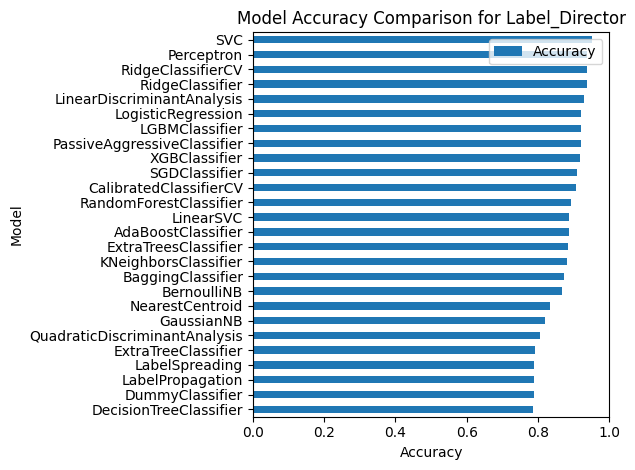


Processing dataset for Label_Vice President


 97%|█████████▋| 28/29 [04:58<00:00,  1.38it/s]

[LightGBM] [Info] Number of positive: 323, number of negative: 1469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.180246 -> initscore=-1.514685
[LightGBM] [Info] Start training from score -1.514685


100%|██████████| 29/29 [04:59<00:00, 10.33s/it]

Model performance for Label_Vice President:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.95,0.95,0.95,0.95,0.07
GaussianNB,0.95,0.94,0.94,0.95,0.12
BernoulliNB,0.96,0.94,0.94,0.96,0.12
SVC,0.96,0.94,0.94,0.96,0.21
LinearDiscriminantAnalysis,0.96,0.94,0.94,0.96,1.41
RidgeClassifierCV,0.96,0.93,0.93,0.96,0.38
RidgeClassifier,0.96,0.93,0.93,0.96,0.19
PassiveAggressiveClassifier,0.96,0.93,0.93,0.96,0.14
LGBMClassifier,0.96,0.93,0.93,0.96,1.33


<Figure size 1000x600 with 0 Axes>

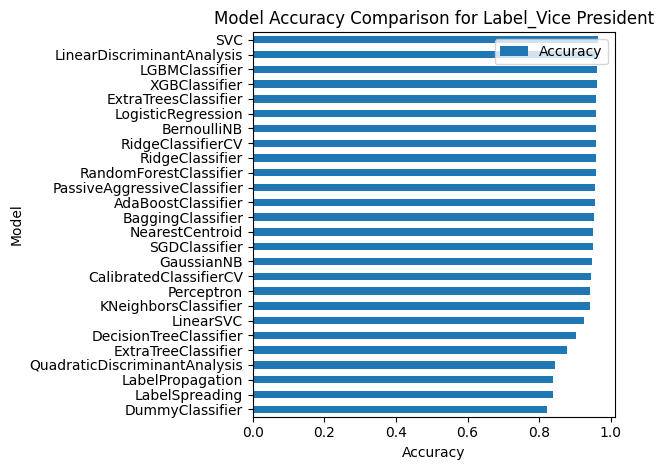


Processing dataset for Label_Manager


 97%|█████████▋| 28/29 [01:24<00:01,  1.02s/it]

[LightGBM] [Info] Number of positive: 168, number of negative: 1624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093750 -> initscore=-2.268684
[LightGBM] [Info] Start training from score -2.268684


100%|██████████| 29/29 [01:26<00:00,  2.97s/it]

Model performance for Label_Manager:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.92,0.76,0.76,0.92,0.64
GaussianNB,0.79,0.75,0.75,0.82,0.06
NearestCentroid,0.78,0.74,0.74,0.82,0.06
BernoulliNB,0.82,0.72,0.72,0.84,0.21
PassiveAggressiveClassifier,0.90,0.72,0.72,0.90,0.07
LogisticRegression,0.92,0.72,0.72,0.91,0.14
RidgeClassifierCV,0.93,0.71,0.71,0.92,1.04
RidgeClassifier,0.93,0.71,0.71,0.92,0.14
Perceptron,0.89,0.69,0.69,0.89,0.07


<Figure size 1000x600 with 0 Axes>

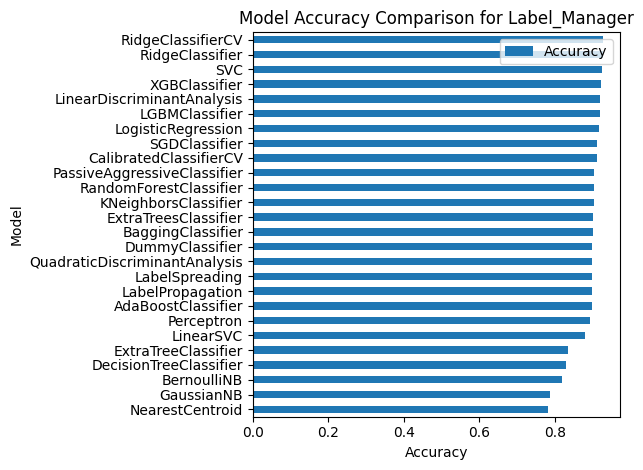


Processing dataset for Label_Chief Officer


 97%|█████████▋| 28/29 [00:52<00:00,  1.30it/s]

[LightGBM] [Info] Number of positive: 136, number of negative: 1656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075893 -> initscore=-2.499505
[LightGBM] [Info] Start training from score -2.499505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:53<00:00,  1.85s/it]

Model performance for Label_Chief Officer:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.96,0.86,0.86,0.96,0.65
GaussianNB,0.90,0.86,0.86,0.92,0.06
BernoulliNB,0.90,0.83,0.83,0.91,0.06
NearestCentroid,0.89,0.82,0.82,0.90,0.05
PassiveAggressiveClassifier,0.95,0.81,0.81,0.95,0.09
KNeighborsClassifier,0.96,0.80,0.80,0.96,0.12
AdaBoostClassifier,0.96,0.78,0.78,0.96,13.79
SVC,0.96,0.78,0.78,0.96,0.19
LogisticRegression,0.95,0.76,0.76,0.95,0.20


<Figure size 1000x600 with 0 Axes>

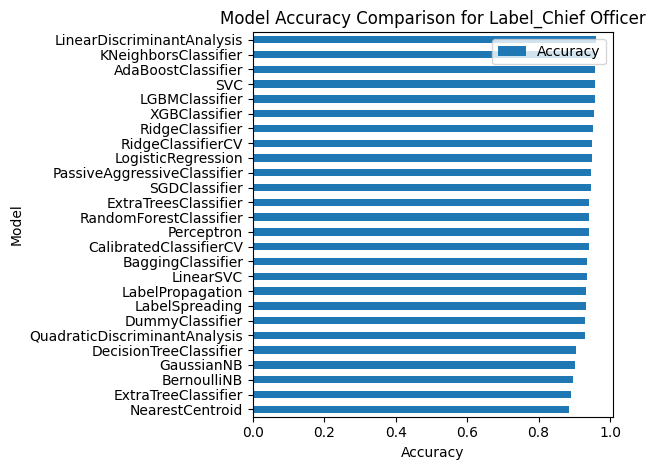


Processing dataset for Label_Owner


 97%|█████████▋| 28/29 [00:18<00:00,  4.79it/s]

[LightGBM] [Info] Number of positive: 2, number of negative: 1118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001786 -> initscore=-6.326149
[LightGBM] [Info] Start training from score -6.326149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

100%|██████████| 29/29 [00:18<00:00,  3.23it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 29/29 [00:18<00:00,  1.54it/s]

Model performance for Label_Owner:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,0.75,0.75,1.00,7.71
LGBMClassifier,1.00,0.75,0.75,1.00,0.72
LogisticRegression,1.00,0.75,0.75,1.00,0.09
SGDClassifier,1.00,0.75,0.75,1.00,0.05
PassiveAggressiveClassifier,1.00,0.75,0.75,1.00,0.07
Perceptron,1.00,0.75,0.75,1.00,0.06
ExtraTreeClassifier,1.00,0.75,0.75,1.00,0.05
LinearDiscriminantAnalysis,1.00,0.75,0.75,1.00,0.70
LinearSVC,1.00,0.75,0.75,1.00,0.17


<Figure size 1000x600 with 0 Axes>

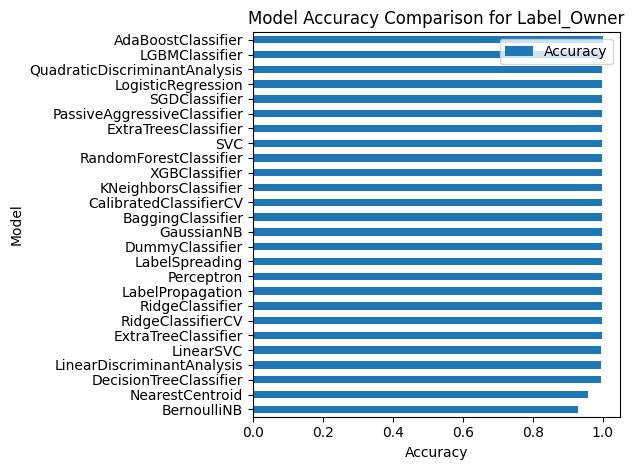

In [13]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Iterate through all datasets
for column, dataset in datasets:
    print(f"\nProcessing dataset for {column}")
    
    X = dataset.drop(column, axis=1)
    y = dataset[column]

    if column == 'Label_Owner':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and fit LazyClassifier
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)

    # Display the results
    print(f"Model performance for {column}:")
    display(models)

    # Plot the results
    plt.figure(figsize=(10, 6))
    models.sort_values(by='Accuracy', ascending=True).plot(kind='barh', y='Accuracy')
    plt.title(f'Model Accuracy Comparison for {column}')
    plt.xlabel('Accuracy')
    plt.tight_layout()
    plt.show()
    